<a href="https://colab.research.google.com/github/AlfonsoPangaribuan/Neural-Machine-Translation-Indonesian-to-Java-IndoBART/blob/main/KELOMPOK_2_NMT_LSTM_BATAK_TOBA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Persiapan Library dan Modul


In [2]:
# Jalankan ini di Colab (cell pertama)
!pip install -q evaluate nltk rouge-score
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# ====== CONFIG & IMPORTS ======
import os
import time
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Evaluation
import evaluate
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 1. Load Dataset dan Cleaning

In [4]:
# ====== 1. LOAD + CLEAN ======
file_path = 'Corpus_Batak - Batak (3).csv'   # <- ganti path bila perlu
df = pd.read_csv(file_path)
df = df.dropna(subset=['Indonesia', 'Batak'])
df['Indonesia'] = df['Indonesia'].astype(str).str.lower().str.strip()
df['Batak'] = df['Batak'].astype(str).str.lower().str.strip()
df = df.rename(columns={"Indonesia":"source", "Batak":"target"})
print("Loaded pairs:", len(df))
print(df.head())

Loaded pairs: 5050
                                              source  \
0  upaya tersebut memang cukup menguntungkan bagi...   
1  dari setiap rp1 juta sekolah bisa menyimpan rp...   
2  karena kekurangpahaman sekolah, pembayaran paj...   
3  akibatnya, perlakuan mengenai hak atas bunga t...   
4  namun, tidak semua pelaksana bos mengetahui te...   

                                              target  
0  angkal tersebut laos ris manghalabahon sagi si...  
1  sian be rp1 juta sikkola boi mangaradoti rp15.000  
2  alani kekurangpahaman sikkola, panggararan bal...  
3  hinorhonna, perlakuan mangonai tohap ginjang b...  
4  alai, ndada luhut pelaksana tokke umboto olap ...  


# 2. Split Dataset

In [5]:
# ====== 2. FIXED SPLITS (TEST FIXED ONCE) ======
train_dev_all, test_fixed = train_test_split(df, test_size=0.1, random_state=SEED, shuffle=True)
train_all, val_df = train_test_split(train_dev_all, test_size=0.05, random_state=SEED, shuffle=True)
print("train_all:", len(train_all), "val:", len(val_df), "test_fixed:", len(test_fixed))
test_fixed.to_csv("test_fixed.csv", index=False)

train_all: 4317 val: 228 test_fixed: 505


# 3. Tokenizer dan bangun Vocab


In [6]:
# ====== 3. TOKENIZER + VOCAB (simple whitespace but consistent) ======
def tokenize(text): return text.split()

def build_vocab_from_df(df_src, df_tgt, tokenizer, max_vocab=30000):
    counter = Counter()
    for s in df_src['source']:
        counter.update(tokenizer(s))
    for t in df_src['target']:
        counter.update(tokenizer(t))
    vocab = {'<pad>':0, '<sos>':1, '<eos>':2, '<unk>':3}
    idx = 4
    for word, _ in counter.most_common(max_vocab):
        if word not in vocab:
            vocab[word] = idx; idx += 1
    return vocab

vocab = build_vocab_from_df(train_all, train_all, tokenize, max_vocab=20000)
source_vocab = vocab
target_vocab = vocab
idx2word = {i:w for w,i in source_vocab.items()}
print("Vocab size:", len(source_vocab))

def text_to_ids(text, vocab, tokenizer):
    toks = tokenizer(text)
    ids = [vocab.get(t, vocab['<unk>']) for t in toks]
    ids = [vocab['<sos>']] + ids + [vocab['<eos>']]
    return torch.LongTensor(ids)

# alias (biar terpakai nama text_to_tensor dalam contoh terjemahan)
def text_to_tensor(text, vocab, tokenizer):
    return text_to_ids(text, vocab, tokenizer)

# mapping index->word untuk target (dipakai di inference)
target_idx2word = {i: w for w, i in target_vocab.items()}  # atau target_idx2word = idx2word jika shared


Vocab size: 10221


In [7]:
# ambil 5 contoh data
sample = train_all.head(5).copy()

# fungsi bantu untuk menampilkan token dan id
def get_tokens_and_ids(text, vocab, tokenizer):
    toks = ['<sos>'] + tokenizer(text) + ['<eos>']
    ids = [vocab.get(t, vocab['<unk>']) for t in toks]
    return toks, ids

# buat kolom token dan id
sample['source_tokens'] = sample['source'].apply(lambda x: get_tokens_and_ids(x, vocab, tokenize)[0])
sample['source_ids']     = sample['source'].apply(lambda x: get_tokens_and_ids(x, vocab, tokenize)[1])
sample['target_tokens'] = sample['target'].apply(lambda x: get_tokens_and_ids(x, vocab, tokenize)[0])
sample['target_ids']     = sample['target'].apply(lambda x: get_tokens_and_ids(x, vocab, tokenize)[1])

# tampilkan tabel
print(sample[['source', 'source_tokens', 'source_ids', 'target', 'target_tokens', 'target_ids']])

                                                 source  \
693   masyarakat desa mundu pesisir juga bisa mengak...   
2150  ada beberapa perbedaan manfaat layanan kesehat...   
2660  proporsi rumah tangga yang memiliki anggota ya...   
4650                    kita perlu setoran untuk mobil.   
4103                           tolong berikan roti itu.   

                                          source_tokens  \
693   [<sos>, masyarakat, desa, mundu, pesisir, juga...   
2150  [<sos>, ada, beberapa, perbedaan, manfaat, lay...   
2660  [<sos>, proporsi, rumah, tangga, yang, memilik...   
4650  [<sos>, kita, perlu, setoran, untuk, mobil., <...   
4103        [<sos>, tolong, berikan, roti, itu., <eos>]   

                                             source_ids  \
693   [1, 36, 30, 694, 1416, 35, 174, 635, 191, 9, 5...   
2150  [1, 32, 93, 695, 1324, 95, 91, 9, 747, 56, 282...   
2660  [1, 133, 58, 156, 9, 112, 275, 9, 1325, 455, 2...   
4650                   [1, 214, 314, 3990, 13, 6458, 2

# 4. Dataloader

In [8]:
# ====== 4. PYTORCH DATASET & DATALOADER ======
class TranslationDatasetTorch(Dataset):
    def __init__(self, df, vocab, tokenizer):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.tokenizer = tokenizer
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        src_ids = text_to_ids(row['source'], self.vocab, self.tokenizer)
        tgt_ids = text_to_ids(row['target'], self.vocab, self.tokenizer)
        return src_ids, tgt_ids

def collate_fn(batch):
    srcs = [item[0] for item in batch]
    tgts = [item[1] for item in batch]
    srcs_p = nn.utils.rnn.pad_sequence(srcs, batch_first=True, padding_value=source_vocab['<pad>'])
    tgts_p = nn.utils.rnn.pad_sequence(tgts, batch_first=True, padding_value=target_vocab['<pad>'])
    return srcs_p, tgts_p

train_ds = TranslationDatasetTorch(train_all, source_vocab, tokenize)
val_ds   = TranslationDatasetTorch(val_df, source_vocab, tokenize)
test_ds  = TranslationDatasetTorch(test_fixed, source_vocab, tokenize)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


# Penerapan Model (encode, attention, decode)

In [9]:
# ====== 5. MODEL (seq2seq + attention) ======
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=source_vocab['<pad>'])
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.lstm(embedded)
        hidden_cat = torch.cat((hidden[0:self.n_layers], hidden[self.n_layers:]), dim=2)
        cell_cat   = torch.cat((cell[0:self.n_layers], cell[self.n_layers:]), dim=2)
        hidden = torch.tanh(self.fc(hidden_cat))
        cell   = torch.tanh(self.fc(cell_cat))
        return outputs, hidden, cell

class Attention(nn.Module):
    def __init__(self, enc_hid, dec_hid):
        super().__init__()
        self.attn = nn.Linear(enc_hid*2 + dec_hid, dec_hid)
        self.v = nn.Linear(dec_hid, 1, bias=False)
    def forward(self, hidden, enc_outputs):
        src_len = enc_outputs.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, enc_outputs), dim=2)))
        scores = self.v(energy).squeeze(2)
        return nn.functional.softmax(scores, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=source_vocab['<pad>'])
        self.attention = attention
        self.lstm = nn.LSTM((enc_hid_dim*2) + emb_dim, dec_hid_dim, n_layers, batch_first=True)
        self.fc_out = nn.Linear((enc_hid_dim*2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_step, hidden, cell, enc_outputs):
        input_step = input_step.unsqueeze(1)
        embedded = self.dropout(self.embedding(input_step))
        a = self.attention(hidden[-1], enc_outputs)
        a = a.unsqueeze(1)
        context = torch.bmm(a, enc_outputs)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        pred = self.fc_out(torch.cat((output.squeeze(1), context.squeeze(1), embedded.squeeze(1)), dim=1))
        return pred, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.shape[0], trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        enc_outs, hidden, cell = self.encoder(src)
        input_tok = trg[:,0]
        for t in range(1, trg_len):
            out, hidden, cell = self.decoder(input_tok, hidden, cell, enc_outs)
            outputs[:,t,:] = out
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = out.argmax(1)
            input_tok = trg[:,t] if teacher_force else top1
        return outputs

# model hyperparams
INPUT_DIM = len(source_vocab)
OUTPUT_DIM = len(source_vocab)
EMB_DIM = 256
ENC_HID_DIM = 256
DEC_HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

enc = Encoder(INPUT_DIM, EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT)
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
dec = Decoder(OUTPUT_DIM, EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, N_LAYERS, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
PAD_IDX = source_vocab['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


# Train dan Eval Function

In [10]:
# ====== 6. TRAIN / EVAL FUNCTIONS ======
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for src, trg in loader:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio=0.5)
        output_dim = output.shape[-1]
        out = output[:,1:,:].reshape(-1, output_dim)
        tg  = trg[:,1:].reshape(-1)
        loss = criterion(out, tg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate_epoch(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0.0)
            output_dim = output.shape[-1]
            out = output[:,1:,:].reshape(-1, output_dim)
            tg  = trg[:,1:].reshape(-1)
            loss = criterion(out, tg)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# greedy decode -> list of token ids per sample
def greedy_decode_batch(model, src_batch, max_len=80):
    model.eval()
    batch_size = src_batch.size(0)
    with torch.no_grad():
        enc_outs, hidden, cell = model.encoder(src_batch.to(device))
        inputs = torch.LongTensor([source_vocab['<sos>']]*batch_size).to(device)
        finished = [False]*batch_size
        preds = [[] for _ in range(batch_size)]
        for _ in range(max_len):
            out, hidden, cell = model.decoder(inputs, hidden, cell, enc_outs)
            top1 = out.argmax(1)
            inputs = top1
            for i, tok in enumerate(top1.cpu().tolist()):
                if not finished[i]:
                    if tok == source_vocab['<eos>']:
                        finished[i] = True
                    else:
                        preds[i].append(tok)
            if all(finished):
                break
    return preds

# Converts lists of token-ids -> strings (joined tokens)
def ids_to_sentence(token_ids, idx2word):
    return " ".join([ idx2word.get(i, '<unk>') for i in token_ids ])

# Compute BLEU1..4 from model + loader (returns floats)
def compute_bleu_nltk_from_preds(model, loader, idx2word, max_len=80):
    hyps = []
    refs = []
    for src, trg in loader:
        preds_ids = greedy_decode_batch(model, src, max_len=max_len)
        for p in preds_ids:
            hyps.append([ idx2word.get(i, '<unk>') for i in p ])
        for i in range(trg.size(0)):
            ref_tokens = []
            for idv in trg[i,1:].cpu().tolist():
                if idv == source_vocab['<eos>']: break
                if idv != source_vocab['<pad>']:
                    ref_tokens.append(idx2word.get(idv, '<unk>'))
            refs.append([ref_tokens])
    smoothing = SmoothingFunction().method4
    bleu1 = corpus_bleu(refs, hyps, weights=(1.0,0,0,0), smoothing_function=smoothing)
    bleu2 = corpus_bleu(refs, hyps, weights=(0.5,0.5,0,0), smoothing_function=smoothing)
    bleu3 = corpus_bleu(refs, hyps, weights=(1/3,1/3,1/3,0), smoothing_function=smoothing)
    bleu4 = corpus_bleu(refs, hyps, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothing)
    return {'bleu1':bleu1,'bleu2':bleu2,'bleu3':bleu3,'bleu4':bleu4}

# Compute ROUGE metrics (average F1 over corpus) using rouge_scorer
def compute_rouge_for_loader(model, loader, idx2word, max_len=80):
    # We'll compute ROUGE-1 (n=1), ROUGE-2 (n=2), ROUGE-L, and ROUGE-S (skip-bigram)
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    scores_acc = {'rouge1':[], 'rouge2':[], 'rougeL':[]}
    for src, trg in loader:
        preds_ids = greedy_decode_batch(model, src, max_len=max_len)
        # build list of predicted strings & reference strings in the same order
        for idx in range(len(preds_ids)):
            pred_ids = preds_ids[idx]
            pred_sent = ids_to_sentence(pred_ids, idx2word)
            # find corresponding ref (from trg batch)
            ref_tokens = []
            for idv in trg[idx,1:].cpu().tolist():
                if idv == source_vocab['<eos>']: break
                if idv != source_vocab['<pad>']:
                    ref_tokens.append(idx2word.get(idv, '<unk>'))
            ref_sent = " ".join(ref_tokens)
            sc = scorer.score(ref_sent, pred_sent)
            # store fmeasure
            for k in scores_acc.keys():
                # rouge_scorer keys: 'rouge1','rouge2','rougeL','rougeS'
                scores_acc[k].append(sc[k].fmeasure)
    # average across corpus
    avg = {k: (np.mean(v) if len(v)>0 else 0.0) for k,v in scores_acc.items()}
    return avg

def compute_loss_and_accuracy(model, loader, criterion, pad_idx=PAD_IDX):
    model.eval()
    tot_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0.0)  # deterministic eval
            output_dim = output.shape[-1]
            out = output[:,1:,:].reshape(-1, output_dim)
            tg  = trg[:,1:].reshape(-1)
            loss = criterion(out, tg)
            tot_loss += loss.item()
            preds = out.argmax(1)
            mask = (tg != pad_idx)
            if mask.sum().item() > 0:
                correct += (preds[mask] == tg[mask]).sum().item()
                total += int(mask.sum().item())
    avg_loss = tot_loss / len(loader)
    acc = correct / total if total > 0 else 0.0
    return avg_loss, acc


In [11]:
N_EPOCHS = 100
best_val_loss = float('inf')
patience = 5
pat_cnt = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

eval_epochs = [10, 40, 70, 100]
saved_checkpoints = []
metrics_list = []

for epoch in range(N_EPOCHS):
    t0 = time.time()
    # training step (mengubah parameter)
    train_loss = train_epoch(model, train_loader, optimizer, criterion)

    # evaluasi token-level loss & accuracy (no teacher forcing)
    train_eval_loss, train_acc = compute_loss_and_accuracy(model, train_loader, criterion)
    val_eval_loss, val_acc = compute_loss_and_accuracy(model, val_loader, criterion)

    scheduler.step(val_eval_loss)

    train_losses.append(train_eval_loss)   # simpan eval-loss agar konsisten plot (bukan internal train loop loss)
    val_losses.append(val_eval_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # best model saving (by val_eval_loss)
    if val_eval_loss < best_val_loss:
        best_val_loss = val_eval_loss
        torch.save(model.state_dict(), "best_seq2seq.pt")
        pat_cnt = 0
    else:
        pat_cnt += 1

    print(f"Epoch {epoch+1}/{N_EPOCHS} — train_loss={train_eval_loss:.4f}, val_loss={val_eval_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f} (took {int(time.time()-t0)}s)")

    # checkpoint + BLEU/ROUGE on requested epochs
    if (epoch+1) in eval_epochs:
        ckpt_name = f"model_epoch{epoch+1}.pt"
        torch.save(model.state_dict(), ckpt_name)
        saved_checkpoints.append(ckpt_name)
        print("Saved", ckpt_name, " — computing BLEU & ROUGE...")
        bleu_scores = compute_bleu_nltk_from_preds(model, test_loader, idx2word, max_len=80)
        rouge_scores = compute_rouge_for_loader(model, test_loader, idx2word, max_len=80)
        metrics_entry = {
            'epoch': epoch+1,
            'bleu1': bleu_scores['bleu1'],
            'bleu2': bleu_scores['bleu2'],
            'bleu3': bleu_scores['bleu3'],
            'bleu4': bleu_scores['bleu4'],
            'rouge1': rouge_scores['rouge1'],
            'rouge2': rouge_scores['rouge2'],
            'rougeL': rouge_scores['rougeL'],
        }
        metrics_list.append(metrics_entry)
        pd.DataFrame(metrics_list).to_csv("metrics_checkpoints.csv", index=False)

    # keep early-stop counter but DO NOT break (per request)
    if pat_cnt >= patience:
        print(f"Early-stop condition met (pat_cnt={pat_cnt}) — continuing training (no break).")

# Save per-epoch stats CSV
pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs
}).to_csv("epoch_level_stats.csv", index_label='epoch_index')


Epoch 1/100 — train_loss=6.6009, val_loss=6.7712, train_acc=0.0914, val_acc=0.0944 (took 15s)
Epoch 2/100 — train_loss=6.0572, val_loss=6.4319, train_acc=0.1472, val_acc=0.1429 (took 16s)
Epoch 3/100 — train_loss=5.0479, val_loss=5.7017, train_acc=0.2357, val_acc=0.2292 (took 15s)
Epoch 4/100 — train_loss=3.8847, val_loss=4.8978, train_acc=0.3431, val_acc=0.3225 (took 14s)
Epoch 5/100 — train_loss=3.0806, val_loss=4.5310, train_acc=0.4236, val_acc=0.3768 (took 14s)
Epoch 6/100 — train_loss=2.5777, val_loss=4.1319, train_acc=0.4872, val_acc=0.4249 (took 14s)
Epoch 7/100 — train_loss=2.0358, val_loss=3.8879, train_acc=0.5726, val_acc=0.4647 (took 15s)
Epoch 8/100 — train_loss=1.1985, val_loss=3.3519, train_acc=0.7478, val_acc=0.5652 (took 15s)
Epoch 9/100 — train_loss=1.1306, val_loss=3.2690, train_acc=0.7507, val_acc=0.5740 (took 14s)
Epoch 10/100 — train_loss=1.1188, val_loss=3.2845, train_acc=0.7510, val_acc=0.5685 (took 14s)
Saved model_epoch10.pt  — computing BLEU & ROUGE...
Epoch 1

# Evaluasi Grafik , Bleu, dan Rouge

Collected metrics (epochs): [10, 40, 70, 100]
Final metrics table saved to final_metrics_table.csv
           bleu1     bleu2     bleu3     bleu4    rouge1    rouge2    rougeL
epoch                                                                      
10     0.637734  0.533595  0.452154  0.387742  0.604709  0.399644  0.601837
40     0.743488  0.671440  0.614544  0.568110  0.694710  0.537075  0.692357
70     0.742996  0.671089  0.614456  0.568254  0.693569  0.536010  0.691217
100    0.742996  0.671089  0.614456  0.568254  0.693569  0.536010  0.691217

BLEU table:
           bleu1     bleu2     bleu3     bleu4
epoch                                        
10     0.637734  0.533595  0.452154  0.387742
40     0.743488  0.671440  0.614544  0.568110
70     0.742996  0.671089  0.614456  0.568254
100    0.742996  0.671089  0.614456  0.568254

ROUGE table:
          rouge1    rouge2    rougeL
epoch                              
10     0.604709  0.399644  0.601837
40     0.694710  0.537075  0.69

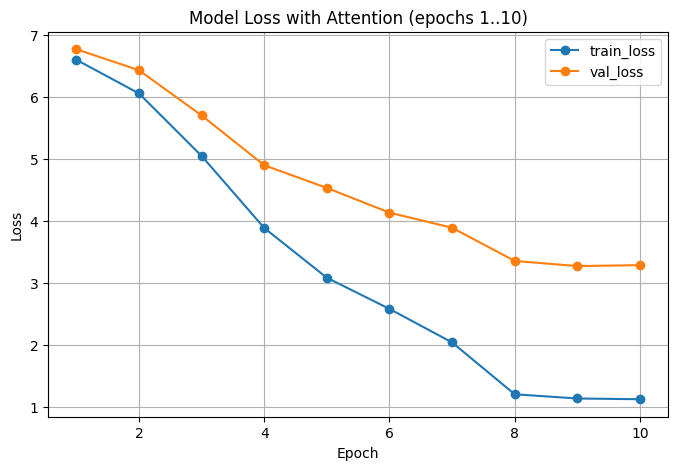

Saved loss_epochs_1_to_10.png


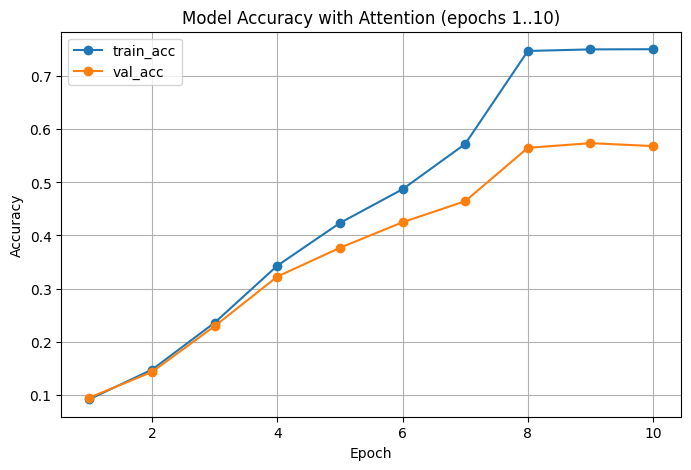

Saved acc_epochs_1_to_10.png


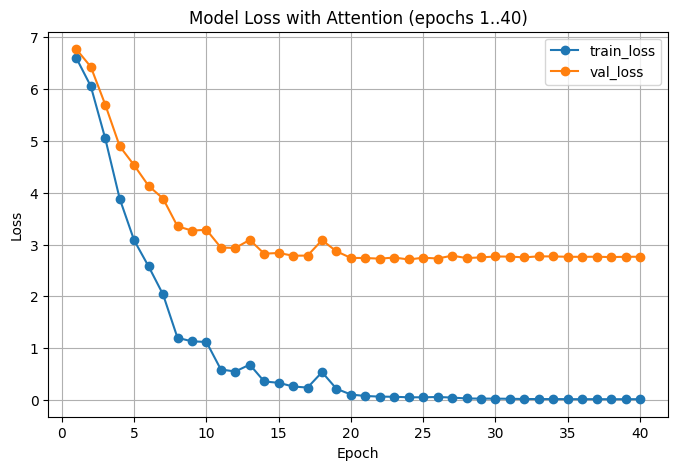

Saved loss_epochs_1_to_40.png


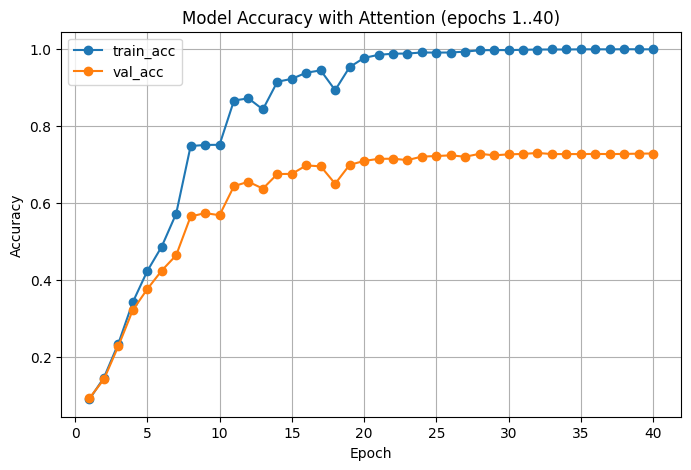

Saved acc_epochs_1_to_40.png


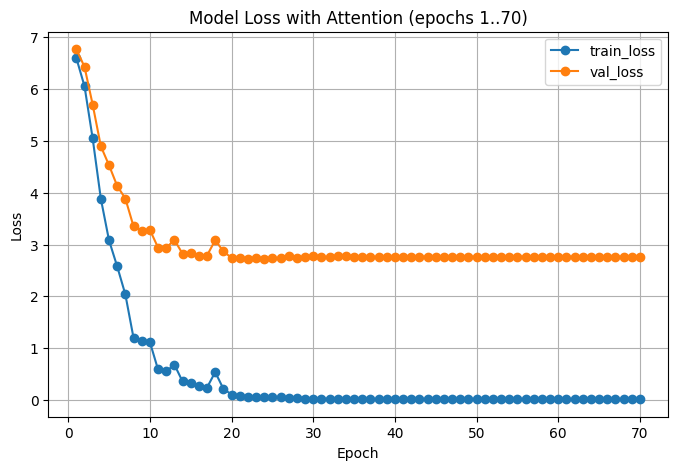

Saved loss_epochs_1_to_70.png


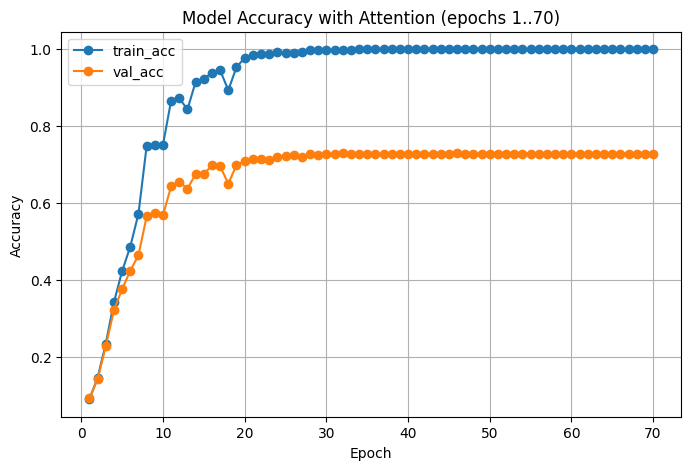

Saved acc_epochs_1_to_70.png


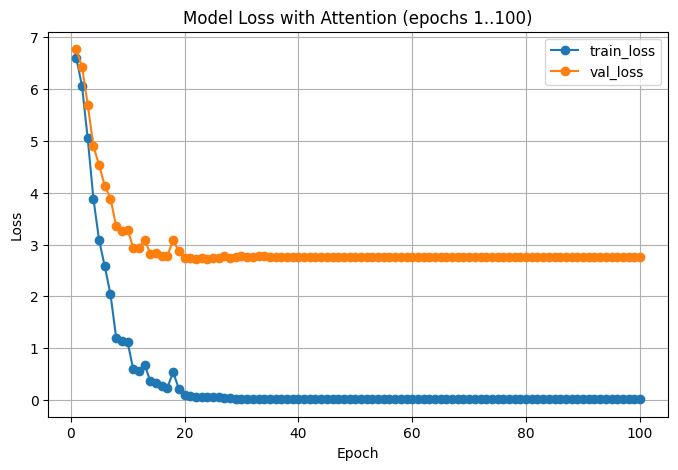

Saved loss_epochs_1_to_100.png


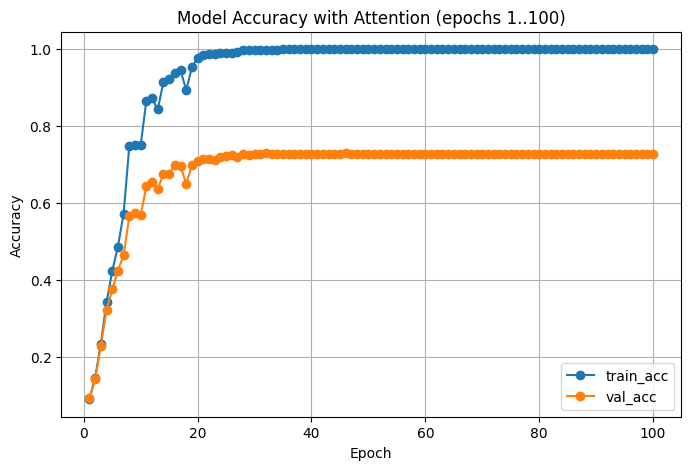

Saved acc_epochs_1_to_100.png


In [12]:
# ====== 8. POST-TRAIN: load saved checkpoints and build final tables/plots ======

# Ensure metrics_list contains possibly partial results from training loop.
metrics_df = pd.DataFrame(metrics_list).set_index('epoch').sort_index()
print("Collected metrics (epochs):", metrics_df.index.tolist())
metrics_df.to_csv("metrics_summary.csv")

# If some checkpoints might not have been computed during training (e.g., early stop)
final_epochs = eval_epochs
final_rows = []
for e in final_epochs:
    ckpt = f"model_epoch{e}.pt"
    if not os.path.exists(ckpt):
        print(f"Checkpoint {ckpt} missing - skipping.")
        continue

    model.load_state_dict(torch.load(ckpt))
    bleu_scores = compute_bleu_nltk_from_preds(model, test_loader, idx2word, max_len=80)
    rouge_scores = compute_rouge_for_loader(model, test_loader, idx2word, max_len=80)

    row = {'epoch': e}
    row.update({f"bleu{i}": bleu_scores[f"bleu{i}"] for i in [1,2,3,4]})
    row.update({
        'rouge1': rouge_scores['rouge1'],
        'rouge2': rouge_scores['rouge2'],
        'rougeL': rouge_scores['rougeL']
    })
    final_rows.append(row)

final_df = pd.DataFrame(final_rows).set_index('epoch').sort_index()
final_df.to_csv("final_metrics_table.csv")
print("Final metrics table saved to final_metrics_table.csv\n", final_df)

# ---- SHOW TABLES ONLY (no BLEU/ROUGE plots) ----
if not final_df.empty:
    bleu_table = final_df[[c for c in final_df.columns if c.startswith('bleu')]]
    rouge_table = final_df[[c for c in final_df.columns if c.startswith('rouge')]]

    print("\nBLEU table:\n", bleu_table)
    print("\nROUGE table:\n", rouge_table)

    bleu_table.to_csv("bleu_table.csv")
    rouge_table.to_csv("rouge_table.csv")
    print("\nSaved: bleu_table.csv, rouge_table.csv")
else:
    print("final_df is empty — no checkpoints found.")


# =====================================================
# === NEW PLOTS: LOSS & ACCURACY (REPLACE BLEU/ROUGE) ==
# =====================================================

stats = pd.read_csv("epoch_level_stats.csv", index_col='epoch_index')
n_epochs_recorded = len(stats)

for E in [10,40,70,100]:
    if E > n_epochs_recorded:
        print(f"Epoch {E} not recorded (skipping).")
        continue

    # ----- LOSS -----
    plt.figure(figsize=(8,5))
    plt.plot(range(1,E+1), stats['train_loss'].values[:E], marker='o', label='train_loss')
    plt.plot(range(1,E+1), stats['val_loss'].values[:E], marker='o', label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(f'Model Loss with Attention (epochs 1..{E})')
    plt.legend(); plt.grid(True)
    fname = f"loss_epochs_1_to_{E}.png"
    plt.savefig(fname, bbox_inches='tight'); plt.show()
    print("Saved", fname)

    # ----- ACCURACY -----
    plt.figure(figsize=(8,5))
    plt.plot(range(1,E+1), stats['train_acc'].values[:E], marker='o', label='train_acc')
    plt.plot(range(1,E+1), stats['val_acc'].values[:E], marker='o', label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title(f'Model Accuracy with Attention (epochs 1..{E})')
    plt.legend(); plt.grid(True)
    fname = f"acc_epochs_1_to_{E}.png"
    plt.savefig(fname, bbox_inches='tight'); plt.show()
    print("Saved", fname)


# SIMULASI TRANSLATE

In [15]:
def translate(sentence, model, vocab, idx2word, tokenizer, max_len=80):
    model.eval()
    # 1. Preprocess
    tokens = tokenizer(sentence.lower().strip())
    ids = [vocab['<sos>']] + [vocab.get(t, vocab['<unk>']) for t in tokens] + [vocab['<eos>']]
    src_tensor = torch.LongTensor(ids).unsqueeze(0).to(device)

    # 2. Encoder
    with torch.no_grad():
        enc_outputs, hidden, cell = model.encoder(src_tensor)

    # 3. Start decoding
    trg_token = vocab['<sos>']
    outputs = []

    for _ in range(max_len):
        trg_tensor = torch.LongTensor([trg_token]).to(device)

        with torch.no_grad():
            pred, hidden, cell = model.decoder(trg_tensor, hidden, cell, enc_outputs)

        trg_token = pred.argmax(1).item()

        if trg_token == vocab['<eos>']:
            break

        outputs.append(trg_token)

    # 4. Convert ids → sentence
    words = [idx2word.get(i, "<unk>") for i in outputs]
    return " ".join(words)


In [27]:
s1 = "secara, hanya separo lebih dari kaum dewasa yang bekerja"
print(translate(s1, model, source_vocab, idx2word, tokenize))

s2 = "akan tetapi, terdapat juga keluarga miskin yang terpaksa menjual aset"
print(translate(s2, model, source_vocab, idx2word, tokenize))

s3 = "makan di hari minggu"
print(translate(s3, model, source_vocab, idx2word, tokenize))


ibana holan separo lobi sian horong toras na markarejo
naeng alai, tardapot musem tondong pogos na tarabuk manggadis aset
mangan i ari minggu i ?
